In [1]:
from math import sin, cos, log
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16

In [2]:
# model parameters:
g = 9.8      # gravity in m s^{-2}
v_t = 4.9    # trim velocity in m s^{-1}   
C_D = 1/5.0  # drag coefficient --- or D/L if C_L=1
C_L = 1.0    # for convenience, use C_L = 1

### set initial conditions ###
v0 = 6.5     # start at the trim velocity (or add a delta)
theta0 = -0.1 # initial angle of trajectory
x0 = 0.0     # horizotal position is arbitrary
y0 = 2.0     # initial altitude

In [37]:
def f(u):
    """Returns the right-hand side of the phugoid system of equations.
    
    Parameters
    ----------
    u : array of float
        array containing the solution at time n.
        
    Returns
    -------
    dudt : array of float
        array containing the RHS given u.
    """
    
    v = u[0]
    theta = u[1]
    x = u[2]
    y = u[3]
    return np.array([-g*sin(theta) - C_D/C_L*g/v_t**2*v**2,
                      -g*cos(theta)/v + g/v_t**2*v,
                      v*cos(theta),
                      v*sin(theta)])


def euler_step(u, f, dt):
    """Returns the solution at the next time-step using Euler's method.
    
    Parameters
    ----------
    u : array of float
        solution at the previous time-step.
    f : function
        function to compute the right hand-side of the system of equation.
    dt : float
        time-increment.
    
    Returns
    -------
    u_n_plus_1 : array of float
        approximate solution at the next time step.
    """
    
    return u + dt * f(u)


def get_diffgrid(u_current, u_fine, dt):
    """Returns the difference between one grid and the fine one using L-1 norm.
    
    Parameters
    ----------
    u_current : array of float
        solution on the current grid.
    u_finest : array of float
        solution on the fine grid.
    dt : float
        time-increment on the current grid.
    
    Returns
    -------
    diffgrid : float
        difference computed in the L-1 norm.
    """
    
    N_current = len(u_current[:,0])
    N_fine = len(u_fine[:,0])
   
    grid_size_ratio = np.ceil(N_fine/N_current)
    
    diffgrid = dt * np.sum( np.abs(u_current[:,2]- u_fine[::grid_size_ratio,2])) 
    
    return diffgrid

In [8]:
def rk2_step(u, f, dt):
    """ Returns the solution at the next time-step using 2nd-order Runge-Kutta.
    
    Parameters
    ----------
    u : array of float
        solution at the provious time step
    f : function
        function to compute the right hand-side of the system of equations
    dt : float
        time-increment.
    
    Returns
    -------
    u_n_plus1 : array of float
        solution at the next time step
    """
    u_star = u + 0.5*dt*f(u)
    return u + dt*f(u_star)

In [11]:
# set time-increment and discretize the time
T = 15.           # final time
dt = 0.01         # set time-increment
N = int(T/dt) + 1 # number of time-steps

# initial conditions
u_euler = np.empty((N, 4))
u_rk2 = np.empty((N, 4))

# initialize the array containting the solution for each time step
u_euler[0] = np.array([v0, theta0, x0, y0])
u_rk2[0] = np.array([v0, theta0, x0, y0])

# use for loop to call the function rd2_step()
for n in range(N-1):
    u_euler[n+1] = euler_step(u_euler[n], f, dt)
    u_rk2[n+1] = rk2_step(u_rk2[n], f, dt)

In [21]:
x_euler = u_euler[:,2]
y_euler = u_euler[:,3]
x_rk2 = u_rk2[:,2]
y_rk2 = u_rk2[:,3]

In [22]:
np.where(y_euler < 0)[0][0]

310

In [23]:
# get index of element of y where altitude becomes negative
idx_negative_euler = np.where(y_euler < 0.0)[0]
if len(idx_negative_euler)==0:
    idx_ground_euler = N-1
    print('Euler integration has not touched ground yet!')
else:
    idx_ground_euler = idx_negative_euler[0]

idx_negative_rk2 = np.where(y_rk2 < 0.0)[0]
if len(idx_negative_rk2)==0:
    idx_ground_rk2 = N-1
    print('Runge-Kutta integration has not touched ground yet!')
else: idx_ground_rk2 = idx_negative_rk2[0]

In [24]:
# check to see if the paths match
print('Are the x-values close? {}'.format(np.allclose(x_euler, x_rk2)))
print('Are the y-values close? {}'.format(np.allclose(y_euler, y_rk2)))

Are the x-values close? False
Are the y-values close? False


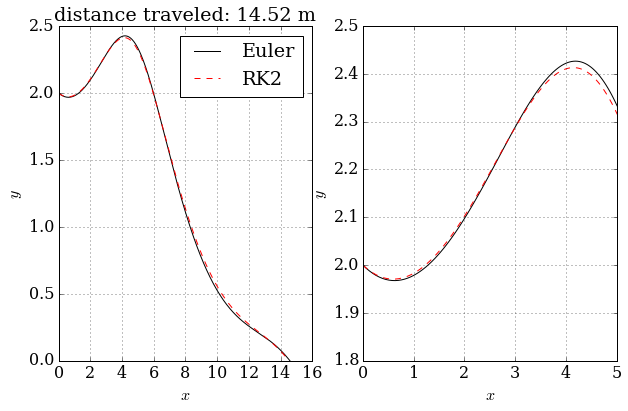

In [34]:
# plot the glider path
plt.figure(figsize=(10,6))
plt.subplot(121)
plt.grid(True)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.plot(x_euler[:idx_ground_euler], y_euler[:idx_ground_euler], 'k-', label='Euler')
plt.plot(x_rk2[:idx_ground_rk2], y_rk2[:idx_ground_rk2], 'r--', label='RK2')
plt.title('distance traveled: {:.2f} m'.format(x_rk2[idx_ground_rk2-1]))
plt.legend()

# taking a closer look
plt.subplot(122)
plt.grid(True)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.plot(x_euler, y_euler, 'k-', label='Euler')
plt.plot(x_rk2, y_rk2, 'r--', label='RK2')
plt.xlim(0,5)
plt.ylim(1.8,2.5);

In [35]:
# use for loop to compute the solution for different grid sizes
dt_values = np.array([0.1, 0.05, 0.01, 0.005, 0.001])
u_values = np.empty_like(dt_values, dtype=np.ndarray)

for i, dt in enumerate(dt_values):
    N = int(T/dt)+1  # number of time-steps
    
    # discretize the time t
    t = np.linspace(0.0, T, N)
    
    # initialize array containing the solution at each time step
    u = np.empty((N, 4))
    u[0] = np.array([v0, theta0, x0, y0])
    
    # time loop
    for n in range(N-1):
        u[n+1] = rk2_step(u[n], f, dt)
        
    # store the value of u related to one grid
    u_values[i] = u

In [38]:
# compute differences
diffgrid = np.empty_like(dt_values)
for i, dt in enumerate(dt_values):
    diffgrid[i] = get_diffgrid(u_values[i], u_values[-1], dt)

/home/gil/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:69: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


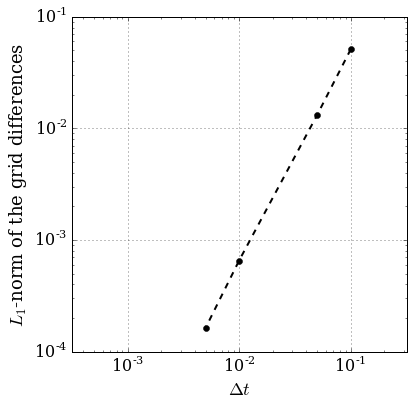

In [46]:
# plot the thing
plt.figure(figsize=(6,6))
plt.grid(True)
plt.xlabel(r'$\Delta t$', fontsize=18)
plt.ylabel(r'$L_1$-norm of the grid differences', fontsize=18)
plt.xlim(1e-4,1)
plt.ylim(1e-4,1)
plt.axis('equal')
plt.loglog(dt_values[:-1], diffgrid[:-1], color='k', ls='--', lw=2, marker='o');

In [50]:
# check the order of convergence
r = 2
h = 0.001
dt_values = np.array([h, r*h, r**2*h])
u_values = np.empty_like(dt_values, dtype=np.ndarray)

for i, dt in enumerate(dt_values):
    N = int(T/dt)+1
    
    # discretize the time
    t = np.linspace(0.0, T, N)
    
    # initialize array containing solution for each time step
    u = np.empty((N, 4))
    u[0] = np.array([v0, theta0, x0, y0])
    
    # time loop
    for n in range(N-1):
        u[n+1] = rk2_step(u[n], f, dt)
    
    # store value of u for each dt
    u_values[i] = u
    
# calculate order of convergence
alpha = (log(get_diffgrid(u_values[2], u_values[1], dt_values[2])) - log(get_diffgrid(u_values[1], u_values[0], dt_values[1])))/log(r)

print('The order of convergence is alpha = {:.3f}'.format(alpha))

The order of convergence is alpha = 1.983


/home/gil/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:69: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


### Challenge task: 

How much time does each calculation method take?

In [52]:
import time

In [54]:
def time_euler():
    # set time-increment and discretize the time
    T = 15.           # final time
    dt = 0.01         # set time-increment
    N = int(T/dt) + 1 # number of time-steps

    # initial conditions
    u_euler = np.empty((N, 4))
    
    # initialize the array containting the solution for each time step
    u_euler[0] = np.array([v0, theta0, x0, y0])
    
    # use for loop to call the function rd2_step()
    for n in range(N-1):
        u_euler[n+1] = euler_step(u_euler[n], f, dt)
    return

def time_rk2():
    # set time-increment and discretize the time
    T = 15.           # final time
    dt = 0.01         # set time-increment
    N = int(T/dt) + 1 # number of time-steps

    # initial conditions
    u_rk2 = np.empty((N, 4))
    
    # initialize the array containting the solution for each time step
    u_rk2[0] = np.array([v0, theta0, x0, y0])
    
    # use for loop to call the function rd2_step()
    for n in range(N-1):
        u_rk2[n+1] = rk2_step(u_euler[n], f, dt)
    return

In [72]:
# time the solutions:
k = int(100) # number of times to run the function and average time over

# time the Euler method
t0 = time.clock()
for i in range(k): time_euler()
t1 = time.clock()
euler_time = (t1-t0)/k*1000 # average time to complete method in miliseconds

# time the RK2 method:
t0 = time.clock()
for i in range(k): time_rk2()
t1 = time.clock()
rk2_time = (t1-t0)/k*1000 # average time to complete method in miliseconds
print('Euler method took: %0.3f miliseconds\nRunga-Kutta 2 method took: %0.3f miliseconds' % (euler_time, rk2_time))

Euler method took: 36.816 miliseconds
Runga-Kutta 2 method took: 48.966 miliseconds


### end of challenge

onto the leapfrog method:

In [75]:
def leapfrog_step(unm1, u, f, dt):
    """ Returns the solution time-step n+1 using a leapfrog method
    
    Parameters
    ----------
    unm1 : array of float
        solutions at time-step n-1.
    u : array of float
        solution at time-step n
    f : function
        function to compute RHS of the system of equations
    dt : float
        time-increment
    """
    return unm1 + 2.0*dt*f(u)

In [74]:
# model parameters:
g = 9.8      # gravity in m s^{-2}
v_t = 4.9    # trim velocity in m s^{-1}   
C_D = 1/5.0  # drag coefficient --- or D/L if C_L=1
C_L = 1.0    # for convenience, use C_L = 1

### set initial conditions ###
v0 = 6.5     # start at the trim velocity (or add a delta)
theta0 = -0.1 # initial angle of trajectory
x0 = 0.0     # horizotal position is arbitrary
y0 = 2.0     # initial altitude

# set time-increment and discretize the time
T  = 15.0                           # final time
dt = 0.01                             # set time-increment
N  = int(T/dt) + 1                   # number of time-steps

# set initial conditions
u_leapfrog = np.empty((N, 4))

# initialize the array containing the solution for each time-step
u_leapfrog[0] = np.array([v0, theta0, x0, y0])

# first step using RK2
u_leapfrog[1] = rk2_step(u_leapfrog[0], f, dt)

In [76]:
# for loop to call leapfrog_step function
for n in range(1,N-1):
    u_leapfrog[n+1] = leapfrog_step(u_leapfrog[n-1], u_leapfrog[n], f, dt)

In [77]:
# get glider spatial coordinates
x_leapfrog = u_leapfrog[:,2]
y_leapfrog = u_leapfrog[:,3]

# get index of element where y becomes negative
idx_negative_leapfrog = np.where(y_leapfrog < 0.0)[0]

if len(idx_negative_leapfrog)==0:
    idx_ground_leapfrog = N-1
    pring('The glider has not reached the ground yet!')
else:
    idx_ground_leapfrog = idx_negative_leapfrog[0]

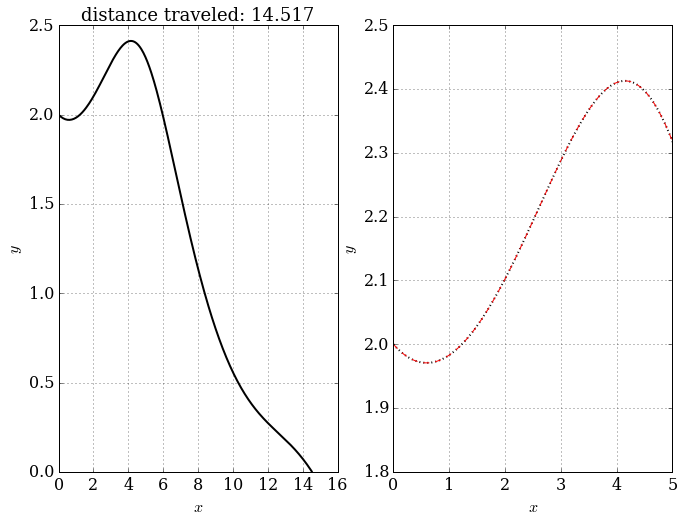

In [78]:
# plot the glider path
plt.figure(figsize=(11,8))
plt.subplot(121)
plt.grid(True)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.plot(x_leapfrog[:idx_ground_leapfrog], y_leapfrog[:idx_ground_leapfrog], color='k', ls='-', lw=2)
plt.title('distance traveled: {:.3f}'.format(x_leapfrog[idx_ground_leapfrog-1]), fontsize=18);

# Let's take a closer look!
plt.subplot(122)
plt.grid(True)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.plot(x_leapfrog[:idx_ground_leapfrog], y_leapfrog[:idx_ground_leapfrog], color='k', ls=':', lw=2)
plt.plot(x_rk2, y_rk2, 'r--', label='RK2')
plt.xlim(0,5)
plt.ylim(1.8,2.5);